In [1]:
%matplotlib inline
import sys, os, glob
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.coordinates import concatenate
plt.rcParams['axes.linewidth'] = 1.5
from astropy.io import fits

### DRW Fitting 

We will use the taufit package to fit a DRW model to the light curve, qualitatively similar to the carm_pack code (Kelly et al. 2009). The code is described at https://github.com/burke86/taufit, and has been validated with simulations.

In [2]:
from taufit.taufit import fit_drw, fit_celerite, hampel_filter, plot_celerite
import corner

In [14]:
# Read data from ZTF CRTS, Pan-STARRs and DR4
# No binning is done, error bars on individual points are handled using Guassian Process likelihood

data_ztf = fits.open('lc.fits')[1].data # ZTF 
df_crts = pd.read_csv('lc_crts.csv') # CRTS
df_ps = pd.read_csv('lc_ps.csv') # Pan-STARRs
df_ps = df_ps[df_ps['filterID']==1]
mag_ps = 8.90 -2.5*np.log10(df_ps['psfFlux'].values)
magerr_ps = 2.5/np.log(10)*df_ps['psfFluxErr'].values/df_ps['psfFlux'].values

In [15]:
g2V = -0.52 # g to V -Band correction

x = np.concatenate([data_ztf['mjd'], df_crts['MJD'].values, df_ps['obsTime'].values])
y = np.concatenate([data_ztf['mag'] + g2V, df_crts['Mag'].values, mag_ps + g2V])
yerr = np.concatenate([data_ztf['magerr'], df_crts['Magerr'].values, magerr_ps])

In [16]:
# sort
idx = np.argsort(x)
x = x[idx]
y = y[idx]
yerr = yerr[idx]

# filter outliers
x, y, outlier_mask = hampel_filter(x, y, 50, n_sigmas=3)
yerr = yerr[~outlier_mask]

# Mask flare
mask_flare = (x < 58650) | (x > 58650+40)

No handles with labels found to put in legend.


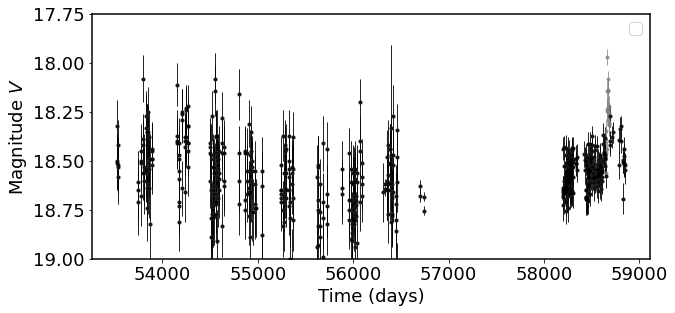

In [17]:
# Add astropy units
x = x*u.day
y = y*u.mag
yerr = yerr*u.mag

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,4.5))

# Light curve & prediction
ax.errorbar(x.value, y.value, yerr=yerr.value, c='grey', fmt='.', alpha=0.75, elinewidth=1)
ax.errorbar(x.value[mask_flare], y.value[mask_flare], yerr=yerr.value[mask_flare], c='k', fmt='.', alpha=0.75, elinewidth=1)

ax.set_xlabel("Time (days)", fontsize=18)
ax.set_ylabel('Magnitude $V$', fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim([17.75, 19.0])
ax.invert_yaxis()
#ax.set_xlim(58000, np.max(t))
ax.legend(fontsize=16, loc=1)

No handles with labels found to put in legend.


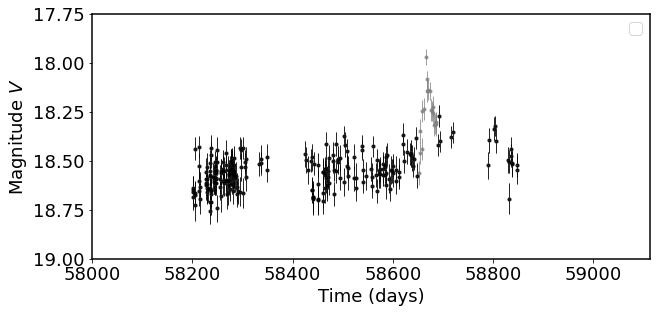

In [18]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(10,4.5))

# Light curve & prediction
ax.errorbar(x.value, y.value, yerr=yerr.value, c='grey', fmt='.', alpha=0.75, elinewidth=1)
ax.errorbar(x.value[mask_flare], y.value[mask_flare], yerr=yerr.value[mask_flare], c='k', fmt='.', alpha=0.75, elinewidth=1)

ax.set_xlabel("Time (days)", fontsize=18)
ax.set_ylabel('Magnitude $V$', fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim([17.75, 19.0])
ax.invert_yaxis()
ax.set_xlim(58000, None)
ax.legend(fontsize=16, loc=1)

Initial log-likelihood: 343.47047964433375
Final log-likelihood: 402.34499171430105
Running burn-in...
Running production...


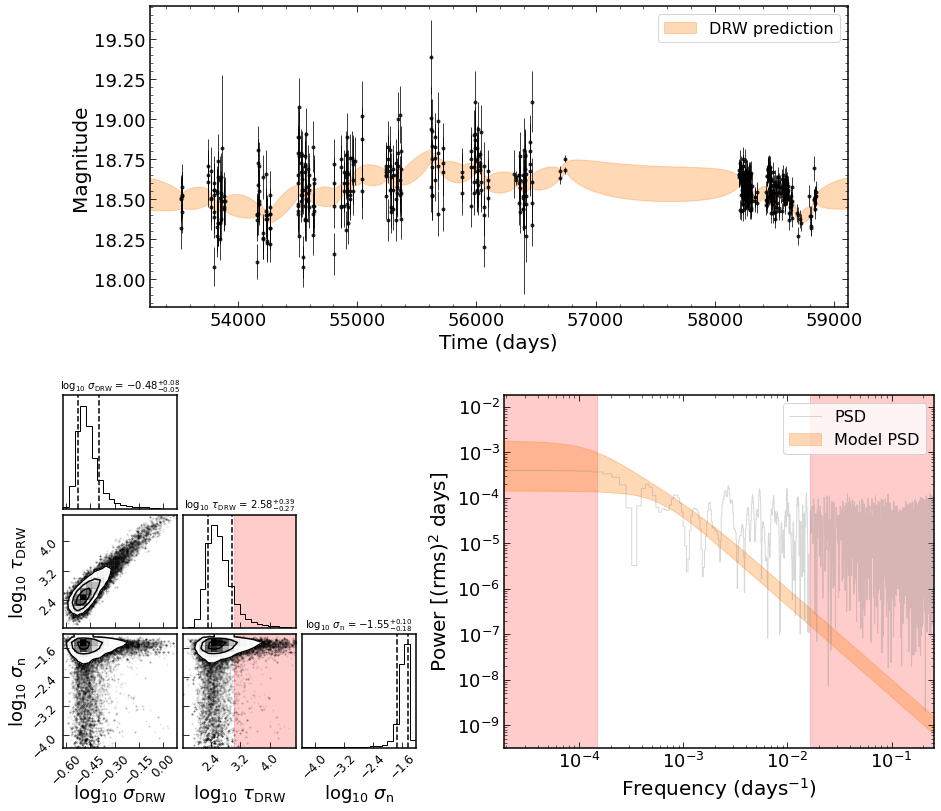

In [19]:
# Fit DRW model without flare

gp, samples, fig = fit_drw(x[mask_flare], y[mask_flare], yerr[mask_flare])

### DRW Fitting Results

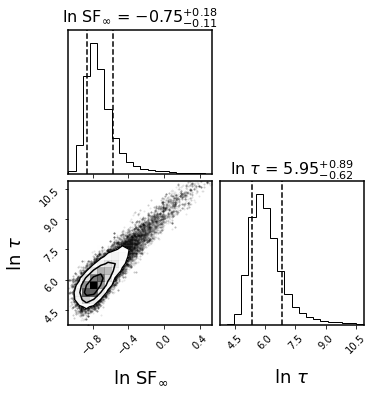

In [23]:
samples_sf = [np.log(np.sqrt(2)*np.sqrt(np.exp(samples[:,0]/2))), np.log(1/np.exp(samples[:,1]))]
samples_sf = np.array(samples_sf).T

fig = corner.corner(samples_sf, quantiles=[0.16,0.84], show_titles=True,
            labels=[r"$\ln\ \rm{SF_{\infty}}$", r"$\ln\ \tau$"],
            label_kwargs=dict(fontsize=18), title_kwargs=dict(fontsize=16));